# Pulling BCN Open data from the API and processing

In [1]:
# This script retrieves the list of organizations from the Open Data API of Barcelona.
# It uses the requests library to make API calls and pandas for data manipulation.
import requests
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

In [2]:
API_URL = "https://portaldades.ajuntament.barcelona.cat/services/backend/rest/statistic/export"

API_KEY = "e58ce2d31573401158da989c0906bb09"

headers = {'Authorization': API_KEY}

## Number of walking journey stages by type of journey stage

In [ ]:
import requests
import pandas as pd
from io import StringIO

# Constants
API_URL = "https://portaldades.ajuntament.barcelona.cat/services/backend/rest/statistic/export"
DATASET_ID = "?id=wc9hkmubl7&fileformat=CSV"
headers = {
    "X-IBM-Client-Id": "e58ce2d31573401158da989c0906bb09"
}

# Fetch CSV content
data_response = requests.get((API_URL + DATASET_ID), headers=headers)

# Load the CSV content into a pandas DataFrame
csv_file = StringIO(data_response.text)
df = pd.read_csv(csv_file, encoding='utf-8')

# Preview the data
print(df.head())


           Dim-00:TEMPS Dim-01:TERRITORI  Dim-01:TERRITORI (order)  \
0  2015-01-01T00:00:00Z        Barcelona                        -1   
1  2015-01-01T00:00:00Z        Barcelona                        -1   
2  2016-01-01T00:00:00Z        Barcelona                        -1   
3  2016-01-01T00:00:00Z        Barcelona                        -1   
4  2017-01-01T00:00:00Z        Barcelona                        -1   

  Dim-01:TERRITORI (type) Dim-02:TIPUS DE ETAPA      VALUE  
0                Municipi             ConnexiÃ³    80657.0  
1                Municipi               Interna  3280032.0  
2                Municipi             ConnexiÃ³    58655.0  
3                Municipi               Interna  2385291.0  
4                Municipi               Interna  2287812.0  


In [ ]:
import datetime
df[df.columns[0]] = pd.to_datetime(df['Dim-00:TEMPS'], utc=True)
df_grouped = df.groupby(df.columns[0]).sum()
df_grouped['VALUE'].plot(title='VALUE over Time')

Looks to be some sort of encoding error here but that's okay. We're just interested in the numbers for now.

## Number of bicycle and personal mobility vehicles (PMV) journey stages by sex and vehicle

In [97]:
DATASET_ID = "?id=5cid3dkbbx&fileformat=CSV"
# Fetch CSV content
data_response = requests.get((API_URL + DATASET_ID), headers=headers)

# Load the CSV content into a pandas DataFrame
csv_file = StringIO(data_response.text)
df = pd.read_csv(csv_file, encoding='utf-8')

# Preview the data
df.head()

,Dim-00:TEMPS,Dim-01:TERRITORI,Dim-01:TERRITORI (order),Dim-01:TERRITORI (type),Dim-02:SEXE,Dim-03:TIPUS DE VEHICLE,VALUE
0,2015-01-01T00:00:00Z,Barcelona,-1,Municipi,Dona,Vehicle mobilitat personal (VMP),0.0
1,2015-01-01T00:00:00Z,Barcelona,-1,Municipi,Home,Vehicle mobilitat personal (VMP),0.0
2,2015-01-01T00:00:00Z,Barcelona,-1,Municipi,Dona,Bicicleta,40738.0
3,2015-01-01T00:00:00Z,Barcelona,-1,Municipi,Home,Bicicleta,81101.0
4,2016-01-01T00:00:00Z,Barcelona,-1,Municipi,Home,Vehicle mobilitat personal (VMP),0.0


In [98]:
df[df.columns[0]] = pd.to_datetime(df['Dim-00:TEMPS'], utc=True)

### Grouped by gender

<Axes: xlabel='Dim-00:TEMPS'>

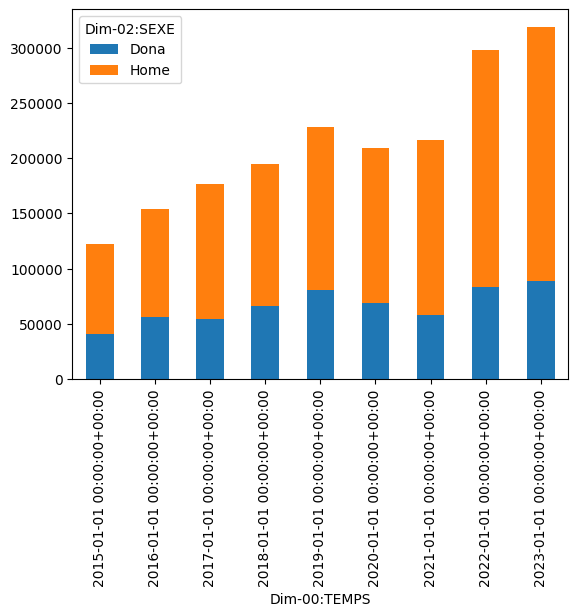

In [107]:
gender_df = df.groupby(['Dim-00:TEMPS', 'Dim-02:SEXE']).sum()
gender_df = gender_df['VALUE'].unstack('Dim-02:SEXE')
gender_df.plot(kind = 'bar', stacked=True)


### Grouped by vehicle

<Axes: xlabel='Dim-00:TEMPS'>

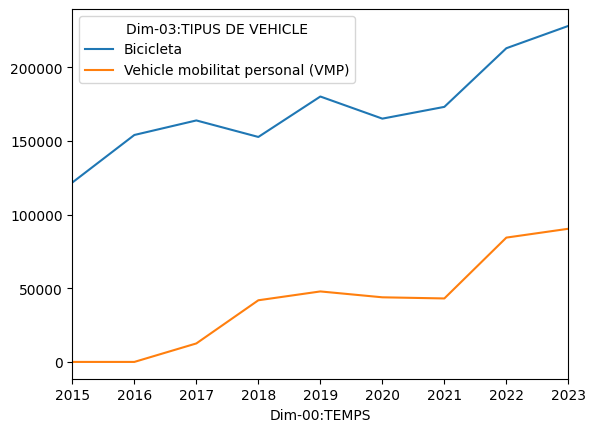

In [108]:
vehicle_df = df.groupby(['Dim-00:TEMPS', 'Dim-03:TIPUS DE VEHICLE']).sum()
vehicle_df = vehicle_df['VALUE'].unstack('Dim-03:TIPUS DE VEHICLE')
vehicle_df.plot()

### Both

<Axes: >

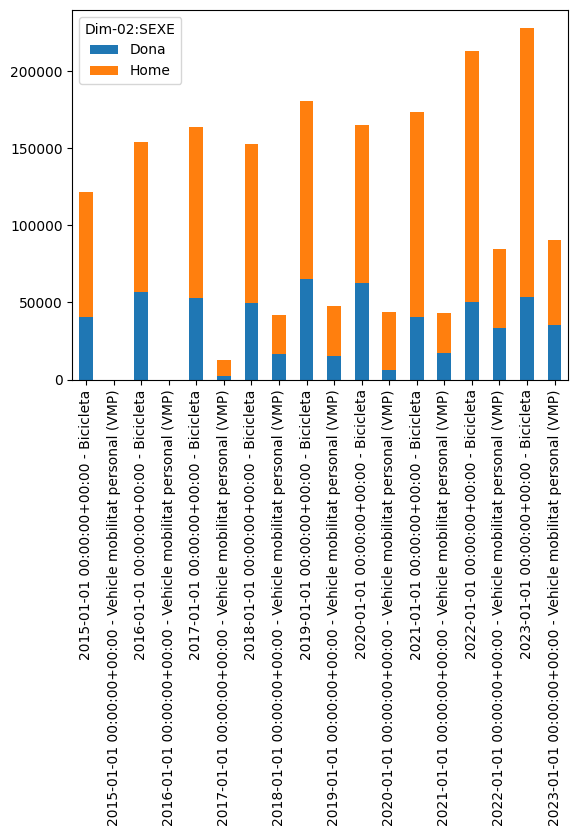

In [113]:
gender_df = df.groupby(['Dim-00:TEMPS', 'Dim-03:TIPUS DE VEHICLE', 'Dim-02:SEXE']).sum()
gender_df = gender_df['VALUE'].unstack('Dim-02:SEXE')
gender_df.index = gender_df.index.map(lambda x: f"{x[0]} - {x[1]}")
gender_df.plot(kind = 'bar', stacked=True)

# Working with databases

## Streets' accessibility in Barcelona city

There are 173144 records here, equating to about 47MB of memory. (to be warned). Given that the API takes a while to load even 10,000 records, perhaps we should include a filter here so that the API only pulls specific barrias? Districts? Situacios? Years?

In [3]:
DATASET_URL = 'https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search'


In [4]:
DATASET_ID = "?resource_id=8c8cbb08-31e1-4c0b-92e5-c01e6598469c"
# Fetch CSV content
data_response = requests.get((DATASET_URL + DATASET_ID), headers=headers, params={'limit': 2000})

# Load the CSV content into a pandas DataFrame
data = data_response.json()
df = pd.DataFrame(data['result']['records'])
df.shape


(2000, 49)

In [6]:
df.columns

Index(['Ubicació', 'Data d'Alta', 'Cas No Compleix Mesura Transv.',
       'Senyalització Vertical', 'Pendent Transversal', 'Gis_ID', 'Llargada',
       'Tipus Direccional', 'Reserva Accesible', 'Alçada', 'Amplada Gual',
       'Pendent Longitudinal', 'Amidament', 'Numero Postal', 'Mesura',
       'Incidència', 'Tipus Botons', 'Carrer', 'Barri', 'Latitud_Y_WGS84',
       'Tipus Pas de Vianants', 'Codi Grafo', 'Situació', 'Falta Direccional',
       'Profunditat', 'Senyalització Horitzontal',
       'Cas No Compleix Mesura Longit.', 'Tipus', 'ALP Central', 'Gis_Y',
       'Gis_X', 'Grao / Desnivell', 'Districte', 'Falta Botons',
       'ID Element Inventari', 'Detall_Altres', 'Quantitat',
       'Tipus tram/carrer', 'N_Gis', 'Accesibilitat', 'Mesura mínima',
       'Pendent', 'ALP Façana', 'Longitud_X_WGS84',
       'Adossat a façana (<0.50m)', 'Data de Baixa', 'Amplada Pas de Vianants',
       '_id', 'Amplada'],
      dtype='object')

In [35]:
# Create a GeoDataFrame from the DataFrame
geometry = [Point(xy) for xy in zip(df['Longitud_X_WGS84'], df['Latitud_Y_WGS84'])]
gdf = gpd.GeoDataFrame(df, geometry = geometry, crs="EPSG:4326")
gdf["lati"] = gdf.geometry.y
gdf["longi"] = gdf.geometry.x
#convert the df into a geodataframe

import plotly.express as px
fig = px.scatter_map(
    gdf,
    lat=gdf['lati'],
    lon=gdf["longi"],
    color='Situació',
    zoom = 10,
    hover_data = {"Data d'Alta":True,
                   "Situació": True,
                   "lati": False,
                   "longi": False},
   )
fig.update_layout(map_style="carto-darkmatter")
fig.show()

### using SQL

In [ ]:
sql = f"""
SELECT *
FROM "{DATASET_ID}"
WHERE "Barri" = '12. la Marina del Prat Vermell'
  AND "Data d'Alta" >= '2022-01-01'
LIMIT 1000
"""

url = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql"
response = requests.get(url, params={"sql": sql})

data = response.json()

# Convert to DataFrame
records = data["result"]["records"]
df = pd.DataFrame(records)
print(df.head())



: 

: 

In [ ]:
import requests
import pandas as pd

resource_id = "8c8cbb08-31e1-4c0b-92e5-c01e6598469c"
sql = f"""
SELECT "Districte", COUNT(*) as count 
FROM "{resource_id}" 
GROUP BY "Districte" 
ORDER BY count DESC
""".replace('\n', '')

url = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql"
response = requests.get(url, params={"sql": sql})

data = response.json()
df = pd.DataFrame(data["result"]["records"])
print(df)


   count                Districte
0  26986  05. Sarria-Sant Gervasi
1  25173       07. Horta-Guinardo
2  22214       03. Sants-Montjuic
3  19173           08. Nou Barris
4  18175           10. Sant Marti
5  17465             02. Eixample
6  14033          09. Sant Andreu
7  13427               06. Gracia
8   8293         01. Ciutat Vella
9   8205            04. Les Corts


: 

: 

In [ ]:
print(df.iloc[0])

Ubicació                                                                       
Data d'Alta                                                 2018-04-13T00:00:00
Cas No Compleix Mesura Transv.                                             None
Senyalització Vertical                                                         
Pendent Transversal                                                            
Gis_ID                                                                       53
Llargada                                                                   None
Tipus Direccional                                                              
Reserva Accesible                                                              
Alçada                                                                       40
Amplada Gual                                                               None
Pendent Longitudinal                                                           
Amidament                               

: 

: 

## Next dataset